# Oxford IIIT Pet


The **Oxford-IIIT Pet Dataset** contains images of 37 different pet breeds, with approximately 200 images per category. Each image comes with:

1. **Breed Labels** – Identifying the species (cat or dog) and exact breed.
2. **Head Bounding Box (ROI)** – A tight bounding box around the pet’s head.
3. **Pixel-Level Trimap Annotations** – Foreground and background segmentation of each pet.

The dataset exhibits wide variations in scale, pose, and lighting, making it well-suited for tasks such as classification, detection, and segmentation within the realm of computer vision and machine learning.


The masks are class-labels for each pixel. Each pixel is given one of three categories:

* Class 1: Pixel belonging to the pet.
* Class 2: Pixel bordering the pet.
* Class 3: None of the above/a surrounding pixel.


[Dataset source](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tarfile 
import pandas as pd
import os
import numpy as np
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
# Initialize notebook constants/config class
class CFG():
    RANDOM_SEED=42
    IMG_HEIGHT=256
    IMG_WIDTH=256
    BATCH_SIZE=16

In [3]:
def extract_tar_files(file_path):
    file = tarfile.open(file_path)
    file.extractall("./")
    file.close()

In [ ]:
extract_tar_files("images.tar.gz")
extract_tar_files("annotations.tar.gz")

In [4]:
with open("../input/the-oxfordiiit-pet-dataset/annotations/annotations/list.txt", "r") as file:
    all_imgs = file.read()
    all_imgs = all_imgs.split("\n")
    all_imgs = all_imgs[6:]
    all_imgs.remove("")

In [5]:
df_imgs = pd.DataFrame([x.strip().split(' ') for x in all_imgs], columns=["image_file", "class_id", "species", "breed_id"])
df_imgs.head()

image_file class_id species breed_id
0  Abyssinian_100        1       1        1
1  Abyssinian_101        1       1        1
2  Abyssinian_102        1       1        1
3  Abyssinian_103        1       1        1
4  Abyssinian_104        1       1        1

In [6]:
## Stratified based on class id, for Test Ds 10% of total
train_ids, test_ids, train_labels, test_labels = train_test_split(df_imgs["image_file"], df_imgs["class_id"], test_size=0.1, stratify=df_imgs["class_id"], random_state=CFG.RANDOM_SEED)

In [7]:
print(f"Sample Train: {train_ids.sample(1)}")
print(f"Sample Test: {test_ids.sample(1)}")

Sample Train: 6950    Siamese_91
Name: image_file, dtype: object
Sample Test: 3613    wheaten_terrier_176
Name: image_file, dtype: object


In [8]:
# Train-Val DS 70-20% of Original len(df_imgs)
train_ids, val_ids, train_labels, val_labels = train_test_split(train_ids, train_labels, test_size=int(len(df_imgs)*0.2), stratify=train_labels, random_state=CFG.RANDOM_SEED)

In [9]:
train_files =  tf.data.Dataset.from_tensor_slices(train_ids) 
val_files = tf.data.Dataset.from_tensor_slices(val_ids) 

In [10]:
@tf.function
def load_image_annotation(img_id: tf.Tensor):
    image_dir = "../input/the-oxfordiiit-pet-dataset/images/images/"
    trimaps_dir = "../input/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps/"

    img_path = tf.strings.join([image_dir, img_id, '.jpg'])
    image_bytes = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (CFG.IMG_HEIGHT, CFG.IMG_WIDTH))

    annotation_path = tf.strings.join([trimaps_dir, img_id, ".png"])
    annotation_bytes = tf.io.read_file(annotation_path)
    annotation = tf.image.decode_png(annotation_bytes, channels=1)
    annotation = tf.image.resize(annotation, (CFG.IMG_HEIGHT, CFG.IMG_WIDTH), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    annotation = tf.squeeze(annotation, axis=-1) 
    annotation = tf.cast(annotation, tf.int32)   
    annotation -= 1                       
    annotation = tf.one_hot(annotation, depth=3)
    annotation = tf.cast(annotation, tf.float32)

    return image, annotation


In [11]:
@tf.function
def apply_data_augmentation(image, annotation):
    # same seed!
    image = tf.image.random_flip_left_right(image, seed=CFG.RANDOM_SEED)
    annotation =  tf.image.random_flip_left_right(annotation, seed=CFG.RANDOM_SEED)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    ## only standardise at rgb since of uint mask
    image = tf.cast(image, tf.float32)
    image = tf.clip_by_value(image, 0.0, 1.0)


    return image, annotation

In [12]:
def configure_performance(ds, apply_augmentation=True):
    if apply_augmentation:
        ds = ds.cache()
        ds = ds.shuffle(1000)
        ds = ds.map(lambda img, annotation: apply_data_augmentation(img, annotation), 
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(CFG.BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:            
        ds = ds.cache()
        ds = ds.batch(CFG.BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [13]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [14]:
train_ds = train_files.map(load_image_annotation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_files.map(load_image_annotation, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [15]:
train_ds = configure_performance(train_ds)
val_ds = configure_performance(val_ds, apply_augmentation=False)

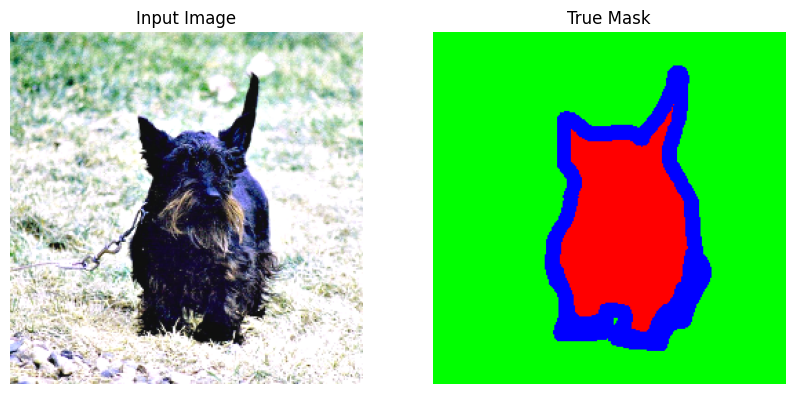

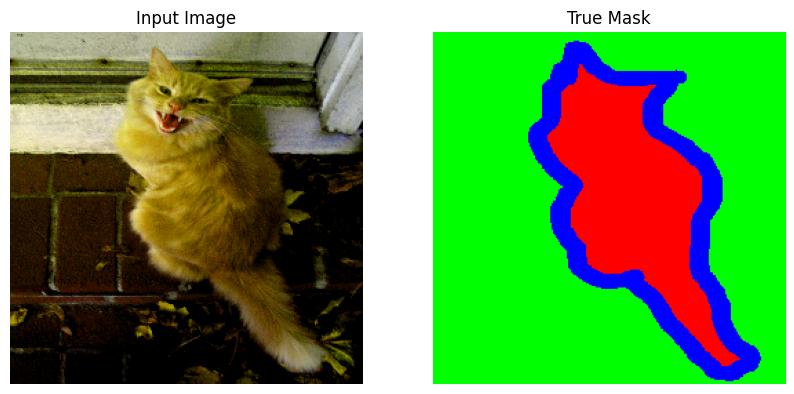

In [16]:
for samples in train_ds.take(2):
    sample_img = (samples[0][0], samples[1][0])
    display(sample_img)

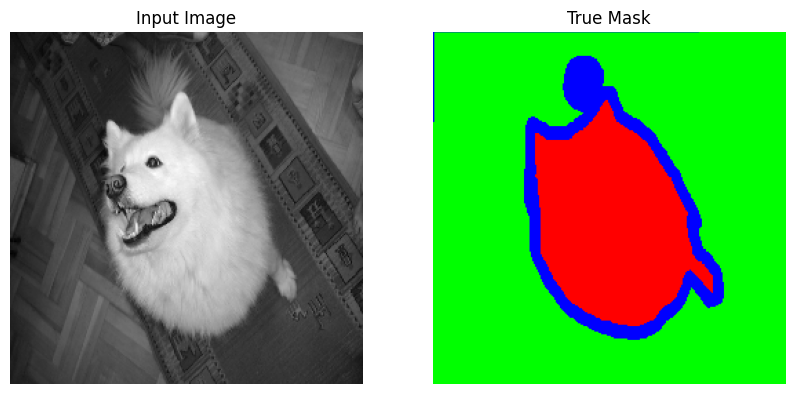

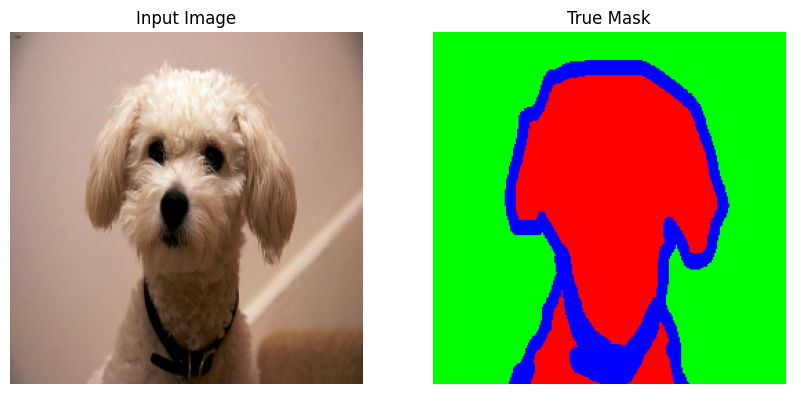

In [17]:
for samples in val_ds.take(2):
    sample_img = (samples[0][0], samples[1][0])
    display(sample_img)

# Define a pretrained U-net

In [ ]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=((CFG.IMG_HEIGHT, CFG.IMG_WIDTH, 3)))

In [ ]:
tf.keras.utils.plot_model(base_model, show_layer_names=True, show_shapes=True)

In [18]:
# References for Conv2DTranspose and VGG16 model
# (1): https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d
# (2): https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16
# (3): https://www.tensorflow.org/tutorials/images/segmentation

def build_unet():
    # Pretrained VGG16 encoder
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(CFG.IMG_HEIGHT, CFG.IMG_WIDTH, 3))
    
    # Encoder layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Skip connections
    s1 = base_model.get_layer('block1_conv2').output  # 256x256
    s2 = base_model.get_layer('block2_conv2').output  # 
    s3 = base_model.get_layer('block3_conv3').output  # 
    s4 = base_model.get_layer('block4_conv3').output  # 32x32
    
    # Bottleneck
    b1 = base_model.get_layer('block5_conv3').output  # 16x16
    
    d1 = tf.keras.layers.Conv2DTranspose(512, (3,3), strides=(2,2), padding='same')(b1)
    d1 = tf.keras.layers.concatenate([d1, s4])
    d1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(d1)
    d1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(d1)
    
    d2 = tf.keras.layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding='same')(d1)
    d2 = tf.keras.layers.concatenate([d2, s3])
    d2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(d2)
    d2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(d2)
    
    d3 = tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(d2)
    d3 = tf.keras.layers.concatenate([d3, s2])
    d3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(d3)
    d3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(d3)
    
    d4 = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(d3)
    d4 = tf.keras.layers.concatenate([d4, s1])
    d4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(d4)
    d4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(d4)
    
    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(d4)
    
    return tf.keras.Model(inputs=base_model.input, outputs=outputs)

In [19]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true, axis=[1,2]) + tf.reduce_sum(y_pred, axis=[1,2])
    dice = (2 * intersection + smooth) / (union + smooth) # multiply by two because of union divider
    
    return 1 - tf.reduce_mean(dice) 

In [20]:
def total_loss(y_true, y_pred):
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return ce + dice

In [23]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5,
    warmup_target=0.001,
    warmup_steps=1605,
    decay_steps=14495,
    alpha=0.0
)

In [24]:
model = build_unet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss=total_loss,
    metrics=['accuracy']
)

In [25]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 179s 441ms/step - accuracy: 0.6714 - loss: 1.2759 - val_accuracy: 0.8635 - val_loss: 0.6393
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 106s 330ms/step - accuracy: 0.8264 - loss: 0.8404 - val_accuracy: 0.8864 - val_loss: 0.5885
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 106s 329ms/step - accuracy: 0.8403 - loss: 0.7905 - val_accuracy: 0.8912 - val_loss: 0.5851
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 106s 329ms/step - accuracy: 0.8463 - loss: 0.7716 - val_accuracy: 0.8901 - val_loss: 0.5904
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 106s 329ms/step - accuracy: 0.8491 - loss: 0.7578 - val_accuracy: 0.8686 - val_loss: 0.6040
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 106s 329ms/step - accuracy: 0.8539 - loss: 0.7369 - val_accuracy: 0.8986 - val_loss: 0.5315
Epoch 7/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 106s 328ms/step - accuracy: 0.8536 - loss: 0.7433 - val_accuracy: 0.8793 - val_loss: 0.5666
Epoch 8/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 106s 328ms/step - accuracy: 0.8541 -

In [26]:
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9076 - loss: 0.4766
Validation Loss: 0.48522379994392395
Validation Accuracy: 0.9056852459907532


In [27]:
predictions = model.predict(val_ds)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


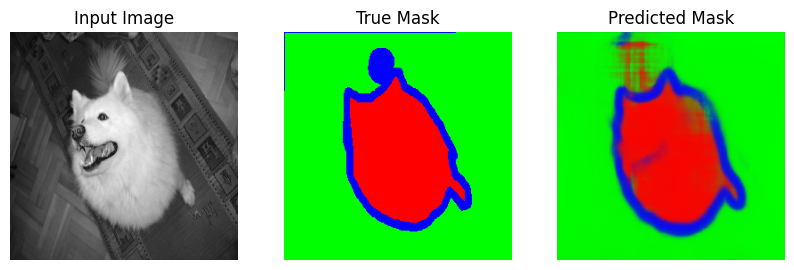

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


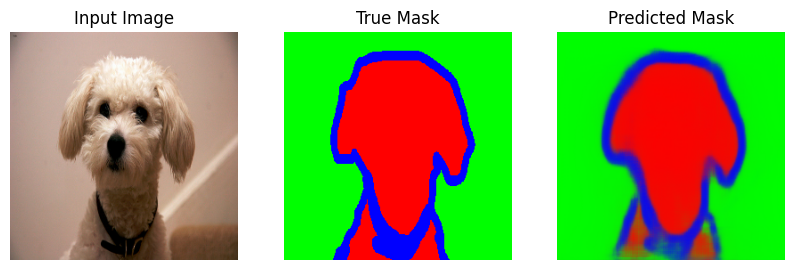

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


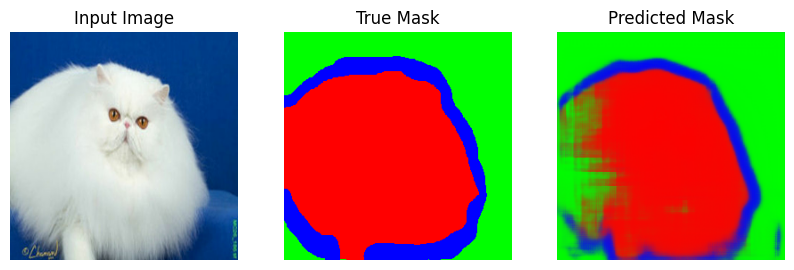

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


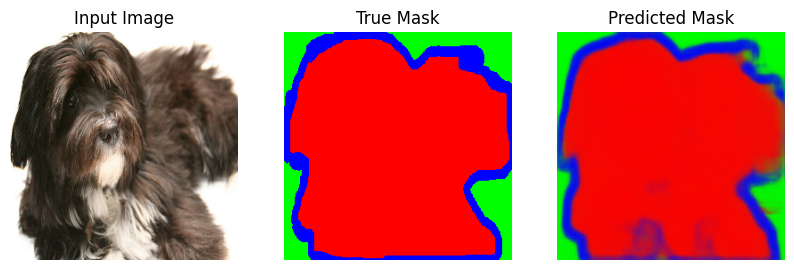

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


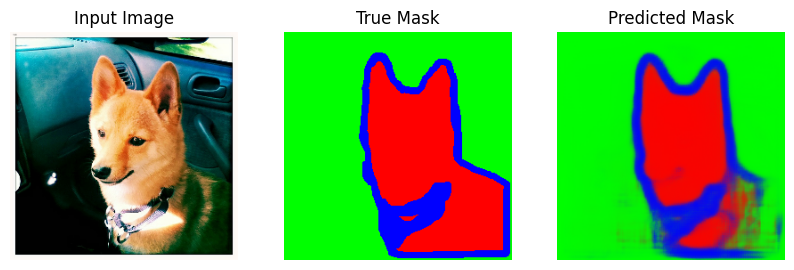

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


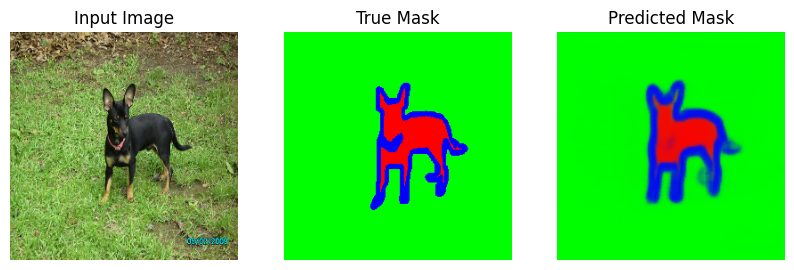

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


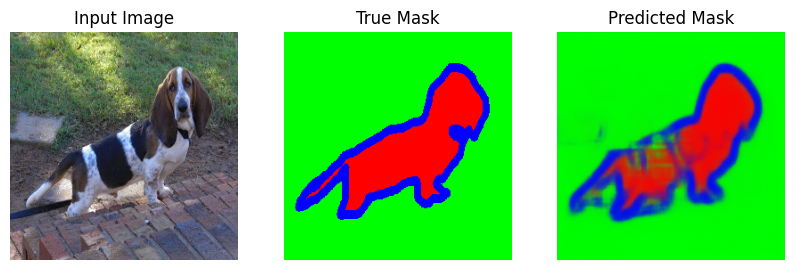

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


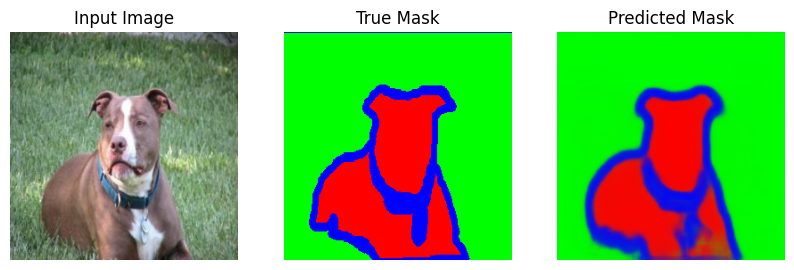

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


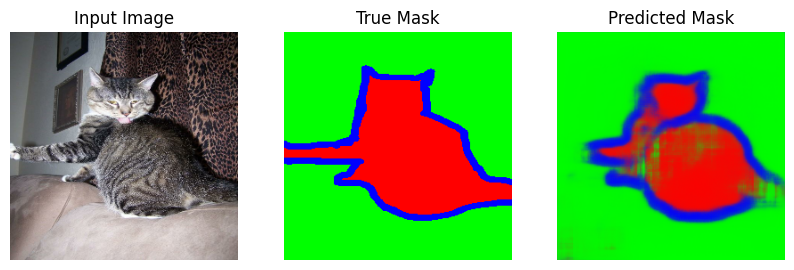

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


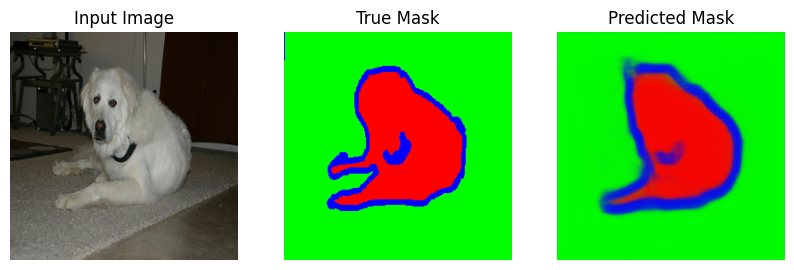

In [28]:
for samples in val_ds.take(10):
    sample_img = (samples[0][0], samples[1][0], model.predict(samples[0])[0])
    display(sample_img)

In [30]:
labels_list = []

for x_batch, y_batch in val_ds:    
    labels_list.append(y_batch.numpy())

labels = np.concatenate(labels_list, axis=0)

In [31]:
pred_class = tf.argmax(predictions, axis=-1)  # shape: (N, H, W)
true_class = tf.argmax(labels, axis=-1)

pred_class = pred_class.numpy()
true_class = true_class.numpy()

In [40]:
num_classes = 3
pred_class_flat = pred_class.reshape(-1)
true_class_flat = true_class.reshape(-1)

conf_mat_tf = tf.math.confusion_matrix(true_class_flat, pred_class_flat, num_classes=num_classes)
conf_mat_norm =  conf_mat_tf / tf.reduce_sum(conf_mat_tf, axis=1, keepdims=True)
conf_mat = conf_mat_tf.numpy()

In [41]:
sum_over_rows = np.sum(conf_mat, axis=0)
sum_over_cols = np.sum(conf_mat, axis=1)
diag = np.diag(conf_mat)
denominator = sum_over_rows + sum_over_cols - diag
iou_per_class = diag / (denominator + 1e-7)
mean_iou = np.mean(iou_per_class)

pixel_accuracy = np.sum(diag) / np.sum(conf_mat)

print("IoU per class:", iou_per_class)
print("Mean IoU:", mean_iou)
print("Pixel-wise Accuracy:", pixel_accuracy)

IoU per class: [0.81935445 0.90142367 0.54239351]
Mean IoU: 0.7543905428582605
Pixel-wise Accuracy: 0.9056851962864034


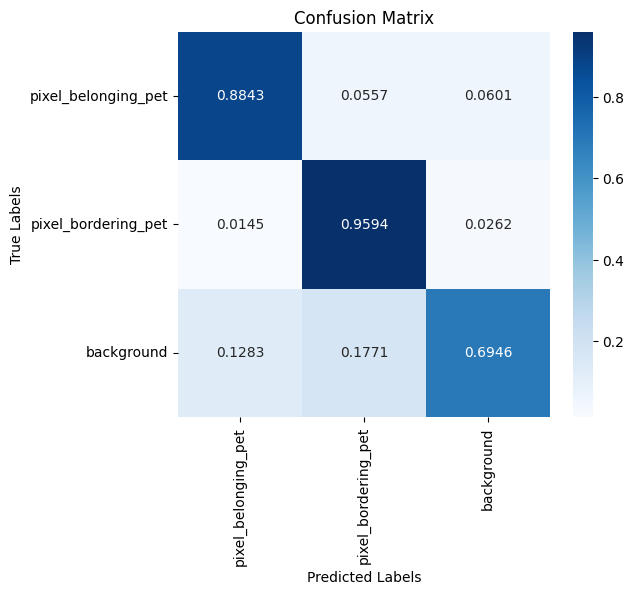

In [42]:
class_names = ["pixel_belonging_pet", "pixel_bordering_pet", "background"] 

plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat_norm, 
    annot=True, 
    fmt='.4f', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Prediction on test set

In [21]:
all_train_files_ds = train_files.concatenate(val_files)
test_files = tf.data.Dataset.from_tensor_slices(test_ids) 

In [22]:
train_ds = all_train_files_ds.map(load_image_annotation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_files.map(load_image_annotation, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [23]:
train_ds = configure_performance(train_ds)
test_ds = configure_performance(test_ds, apply_augmentation=False)

In [ ]:
del base_model, model
K.clear_session()

In [ ]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=((CFG.IMG_HEIGHT, CFG.IMG_WIDTH, 3)))

In [26]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5,
    warmup_target=0.001,
    warmup_steps=1605,
    decay_steps=14495,
    alpha=0.0
)

In [27]:
model = build_unet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss=total_loss,
    metrics=['accuracy']
)

In [28]:
EPOCHS = 15

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
)

Epoch 1/15
414/414 ━━━━━━━━━━━━━━━━━━━━ 197s 385ms/step - accuracy: 0.6951 - loss: 1.2976 - val_accuracy: 0.8800 - val_loss: 0.5984
Epoch 2/15
414/414 ━━━━━━━━━━━━━━━━━━━━ 128s 309ms/step - accuracy: 0.8326 - loss: 0.8210 - val_accuracy: 0.8942 - val_loss: 0.5672
Epoch 3/15
414/414 ━━━━━━━━━━━━━━━━━━━━ 128s 308ms/step - accuracy: 0.8467 - loss: 0.7623 - val_accuracy: 0.8931 - val_loss: 0.5690
Epoch 4/15
414/414 ━━━━━━━━━━━━━━━━━━━━ 127s 308ms/step - accuracy: 0.8467 - loss: 0.7759 - val_accuracy: 0.8995 - val_loss: 0.5039
Epoch 5/15
414/414 ━━━━━━━━━━━━━━━━━━━━ 127s 308ms/step - accuracy: 0.8456 - loss: 0.7729 - val_accuracy: 0.9007 - val_loss: 0.5042
Epoch 6/15
414/414 ━━━━━━━━━━━━━━━━━━━━ 127s 308ms/step - accuracy: 0.8527 - loss: 0.7500 - val_accuracy: 0.9035 - val_loss: 0.4834
Epoch 7/15
414/414 ━━━━━━━━━━━━━━━━━━━━ 127s 307ms/step - accuracy: 0.8590 - loss: 0.7218 - val_accuracy: 0.9085 - val_loss: 0.4530
Epoch 8/15
414/414 ━━━━━━━━━━━━━━━━━━━━ 127s 308ms/step - accuracy: 0.8617 -

In [29]:
loss, accuracy = model.evaluate(test_ds)
print("Validation Loss:", loss)
print("Test Accuracy:", accuracy)

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9106 - loss: 0.4371
Validation Loss: 0.42561301589012146
Test Accuracy: 0.9130353927612305


In [30]:
predictions = model.predict(test_ds)

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


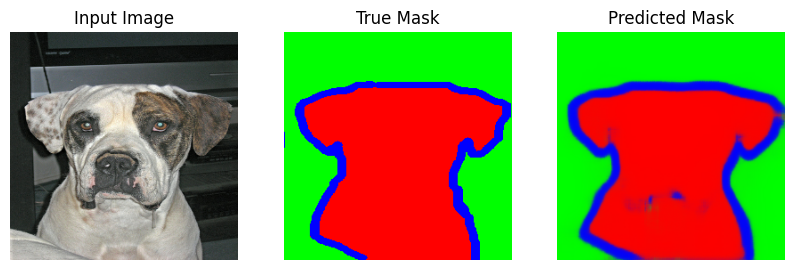

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


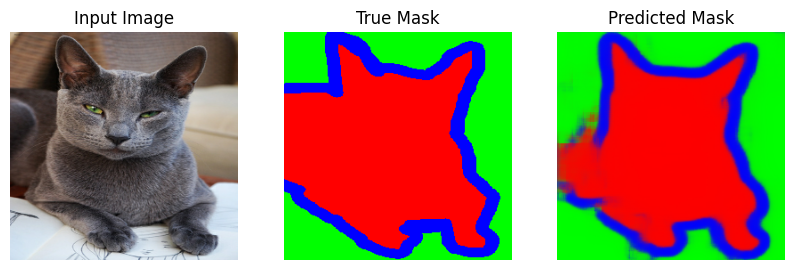

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


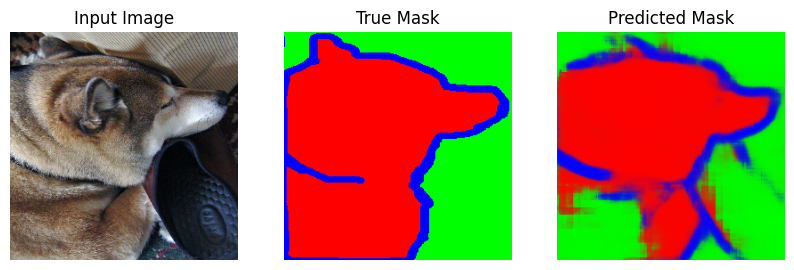

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


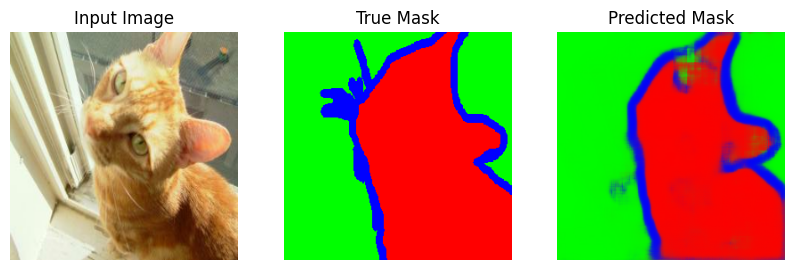

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


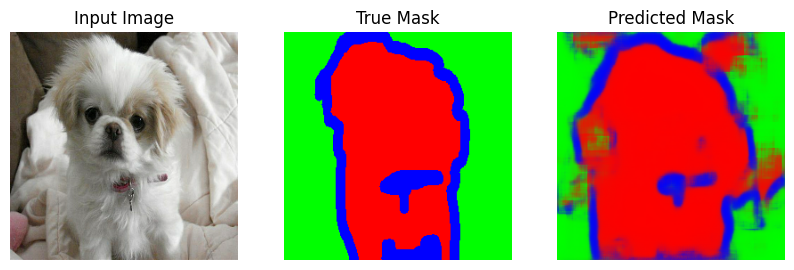

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


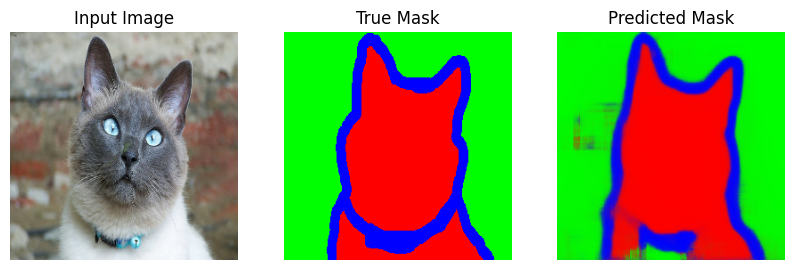

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


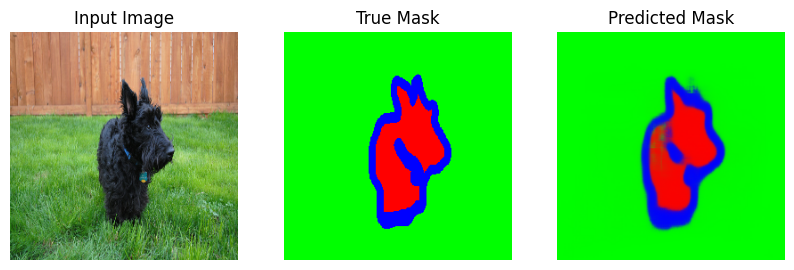

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


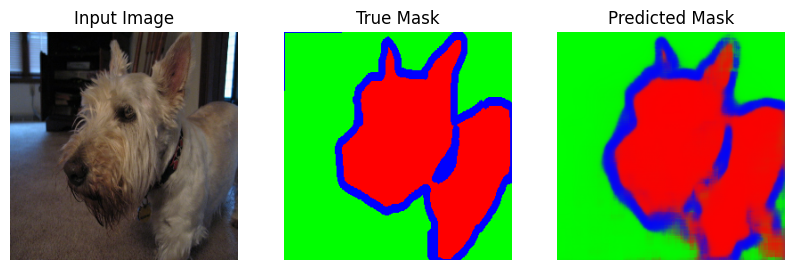

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


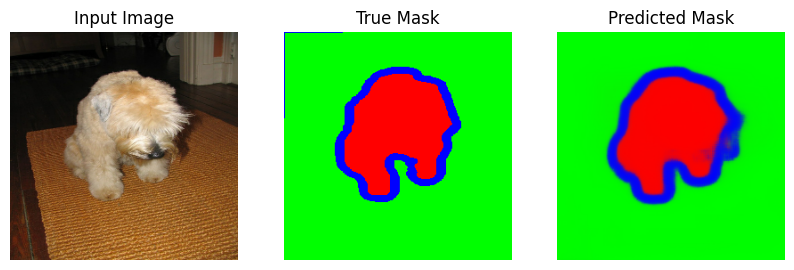

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


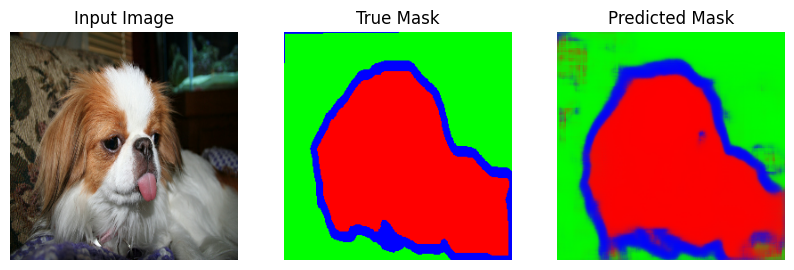

In [31]:
for samples in test_ds.take(10):
    sample_img = (samples[0][0], samples[1][0], model.predict(samples[0])[0])
    display(sample_img)

In [32]:
labels_list = []

for x_batch, y_batch in test_ds:    
    labels_list.append(y_batch.numpy())

labels = np.concatenate(labels_list, axis=0)

In [33]:
pred_class = tf.argmax(predictions, axis=-1)  # shape: (N, H, W)
true_class = tf.argmax(labels, axis=-1)

pred_class = pred_class.numpy()
true_class = true_class.numpy()

In [34]:
num_classes = 3
pred_class_flat = pred_class.reshape(-1)
true_class_flat = true_class.reshape(-1)

conf_mat_tf = tf.math.confusion_matrix(true_class_flat, pred_class_flat, num_classes=num_classes)
conf_mat_norm =  conf_mat_tf / tf.reduce_sum(conf_mat_tf, axis=1, keepdims=True)
conf_mat = conf_mat_tf.numpy()

In [35]:
sum_over_rows = np.sum(conf_mat, axis=0)
sum_over_cols = np.sum(conf_mat, axis=1)
diag = np.diag(conf_mat)
denominator = sum_over_rows + sum_over_cols - diag
iou_per_class = diag / (denominator + 1e-7)
mean_iou = np.mean(iou_per_class)

pixel_accuracy = np.sum(diag) / np.sum(conf_mat)

print("IoU per class:", iou_per_class)
print("Mean IoU:", mean_iou)
print("Pixel-wise Accuracy:", pixel_accuracy)

IoU per class: [0.84040657 0.91053049 0.56667918]
Mean IoU: 0.772538745677999
Pixel-wise Accuracy: 0.9130352201915922


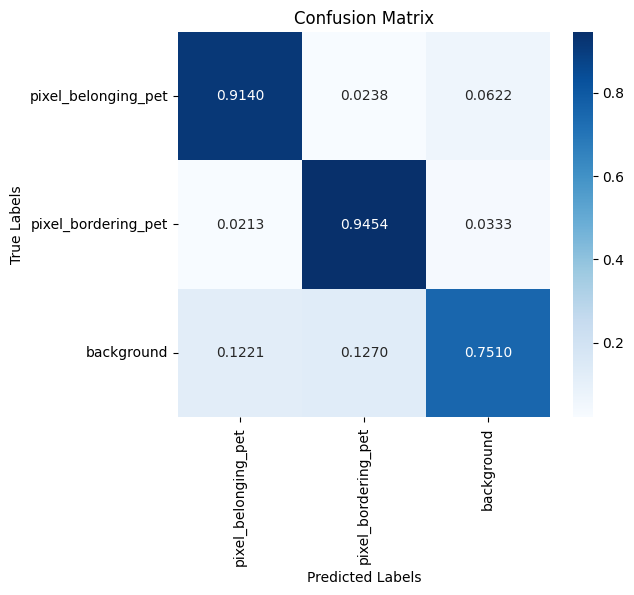

In [36]:
class_names = ["pixel_belonging_pet", "pixel_bordering_pet", "background"] 

plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat_norm, 
    annot=True, 
    fmt='.4f', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()